In [21]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [22]:
#Package calls
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Load the CSV file
df = pd.read_csv("dataset_bnkcafe-Copy1.csv")

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Set the date column as the index
df.set_index('Date', inplace=True)

# Resample the data to monthly frequency and sum the sales for each month
monthly_sales = df.resample('ME').sum()

# Reset index to make the date column a regular column again if needed
monthly_sales.reset_index(inplace=True)
df = monthly_sales

# Print the monthly sales data
print(df)

# Save the monthly sales data to a CSV file
monthly_sales.to_csv('monthly_sales.csv', index=False)

         Date   Sales
0  2021-01-31  589518
1  2021-02-28  573865
2  2021-03-31  560862
3  2021-04-30  503213
4  2021-05-31  556446
5  2021-06-30  405590
6  2021-07-31  405595
7  2021-08-31  410385
8  2021-09-30  437070
9  2021-10-31  482236
10 2021-11-30  472916
11 2021-12-31  702809
12 2022-01-31  561304
13 2022-02-28  577904
14 2022-03-31  653346
15 2022-04-30  913756
16 2022-05-31  895237
17 2022-06-30  668534
18 2022-07-31  509207
19 2022-08-31  421632
20 2022-09-30  586606
21 2022-10-31  674642
22 2022-11-30  541713
23 2022-12-31  643900


In [24]:
# Normalize the sales data using Min-Max Scaling
scaler = MinMaxScaler()

# Normalize Sales
monthly_sales['Normalized_Sales'] = scaler.fit_transform(monthly_sales[['Sales']])

# Print the normalized monthly sales data
print(monthly_sales)

# Save the normalized monthly sales data to a CSV file
monthly_sales.to_csv('normalized_monthly_sales.csv', index=True)

         Date   Sales  Normalized_Sales
0  2021-01-31  589518          0.361945
1  2021-02-28  573865          0.331142
2  2021-03-31  560862          0.305554
3  2021-04-30  503213          0.192108
4  2021-05-31  556446          0.296864
5  2021-06-30  405590          0.000000
6  2021-07-31  405595          0.000010
7  2021-08-31  410385          0.009436
8  2021-09-30  437070          0.061948
9  2021-10-31  482236          0.150829
10 2021-11-30  472916          0.132488
11 2021-12-31  702809          0.584886
12 2022-01-31  561304          0.306423
13 2022-02-28  577904          0.339090
14 2022-03-31  653346          0.487549
15 2022-04-30  913756          1.000000
16 2022-05-31  895237          0.963557
17 2022-06-30  668534          0.517437
18 2022-07-31  509207          0.203904
19 2022-08-31  421632          0.031568
20 2022-09-30  586606          0.356214
21 2022-10-31  674642          0.529457
22 2022-11-30  541713          0.267871
23 2022-12-31  643900          0.468961


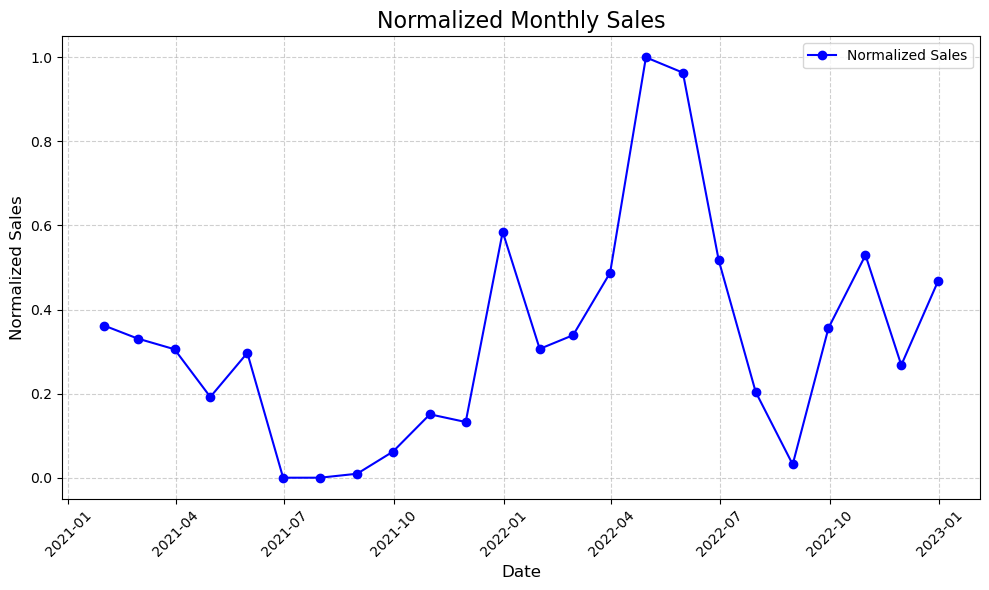

In [25]:
# Plot the normalized monthly sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['Date'], monthly_sales['Normalized_Sales'], marker='o', linestyle='-', color='b', label='Normalized Sales')

# Add titles and labels
plt.title('Normalized Monthly Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Sales', fontsize=12)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Training data: 19 rows
Test data: 5 rows


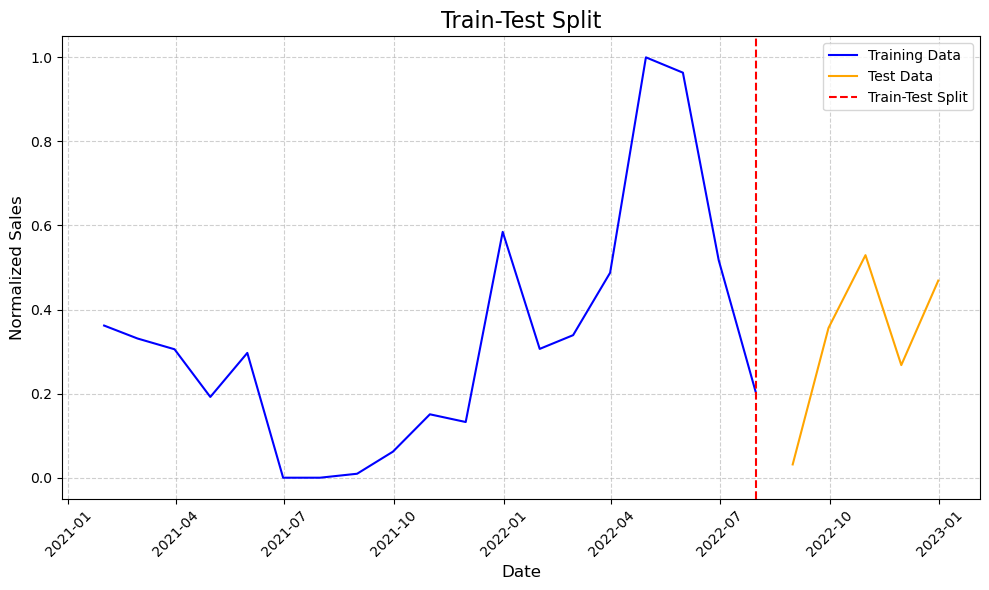

In [26]:
# Calculate the split index
split_index = int(len(monthly_sales) * 0.8)

# Split the data
train_data = monthly_sales.iloc[:split_index]
test_data = monthly_sales.iloc[split_index:]

# Print the number of rows in each set
print(f"Training data: {len(train_data)} rows")
print(f"Test data: {len(test_data)} rows")

# Plot train and test data
plt.figure(figsize=(10, 6))
plt.plot(train_data['Date'], train_data['Normalized_Sales'], label='Training Data', color='blue')
plt.plot(test_data['Date'], test_data['Normalized_Sales'], label='Test Data', color='orange')

# Add a vertical line to indicate the split
split_date = train_data['Date'].iloc[-1]  # The last date in the training set
plt.axvline(x=split_date, color='red', linestyle='--', label='Train-Test Split')

# Add labels, title, and legend
plt.title('Train-Test Split', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Sales', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

In [27]:
def create_features(df):
    """
    Create time series features from a date column or index safely.
    """
    df = df.copy()

    # Determine the date source
    if 'Date' in df.columns:
        # If Date is a column, convert it to datetime first
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        date_source = df['Date']
    elif isinstance(df.index, pd.DatetimeIndex):
        # If index is already DateTimeIndex
        date_source = df.index
    else:
        raise ValueError("No valid date source available in DataFrame.")

    # Ensure the date source is datetime (use .dt safely now)
    df['month'] = date_source.dt.month
    df['year'] = date_source.dt.year
    df['week'] = date_source.dt.isocalendar().week
    df['lag_1'] = df['Sales'].shift(1)

    # Drop rows with NaN values that might arise from lag features
    df = df.dropna()

    return df


In [28]:
FEATURES = ['month', 'year', 'week', 'lag_1']
TARGET = ['Normalized_Sales']

In [29]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              24 non-null     datetime64[ns]
 1   Sales             24 non-null     int64         
 2   Normalized_Sales  24 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 708.0 bytes
None


In [30]:
train_data = create_features(train_data)
test_data = create_features(test_data)

In [31]:
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

print(X_train.head())
print(y_train.head())

   month  year  week     lag_1
1      2  2021     8  589518.0
2      3  2021    13  573865.0
3      4  2021    17  560862.0
4      5  2021    22  503213.0
5      6  2021    26  556446.0
   Normalized_Sales
1          0.331142
2          0.305554
3          0.192108
4          0.296864
5          0.000000


In [32]:
# SVM IMPLEMENTATION

In [33]:
# Ensure target variable is 1D
y_train = y_train.values.ravel()  # Flatten the target array

# Define parameter grid for SVM tuning
param_grid = {
    'C': [0.1, 1, 10, 50, 100],  # Regularization strength
    'epsilon': [0.01, 0.1, 0.5, 1],  # Epsilon tube for regression
    'kernel': ['linear', 'rbf', 'poly']  # Kernel types
}

# Perform GridSearchCV with corrected training shapes
grid_search = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract the best model
best_model = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters found: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'}


In [34]:
# Train the model using the best hyperparameters found
best_model.fit(X_train, y_train)

SVR(C=0.1, kernel='poly')

In [59]:
# Make predictions
predSVR = best_model.predict(X_test)

# Calculate evaluation metrics
rmse_SVR = mean_squared_error(y_test, predSVR, squared=False)  # RMSE
mape_SVR = mean_absolute_percentage_error(y_test, predSVR)

# Print evaluation metrics
print(f"Root Mean Square Error (RMSE): {rmse_SVR}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_SVR}")


Root Mean Square Error (RMSE): 0.21269105589057943
Mean Absolute Percentage Error (MAPE): 0.47797642683854846


C:\Users\Jay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [79]:
# Generate predictions for training and testing datasets
pred_train_svr = best_model.predict(X_train)
pred_test_svr = best_model.predict(X_test)

# Calculate R-squared for training and testing
r2_train_svr = r2_score(y_train, pred_train_svr)
r2_test_svr = r2_score(y_test, pred_test_svr)

# Display R-squared results
print(f"R-squared (Train) for SVR: {r2_train_svr:.2f}")
print(f"R-squared (Test) for SVR: {r2_test_svr:.2f}")

R-squared (Train) for SVR: 0.38
R-squared (Test) for SVR: -3.44


In [81]:
# Predict on the training set
train_predictions = best_model.predict(X_train)

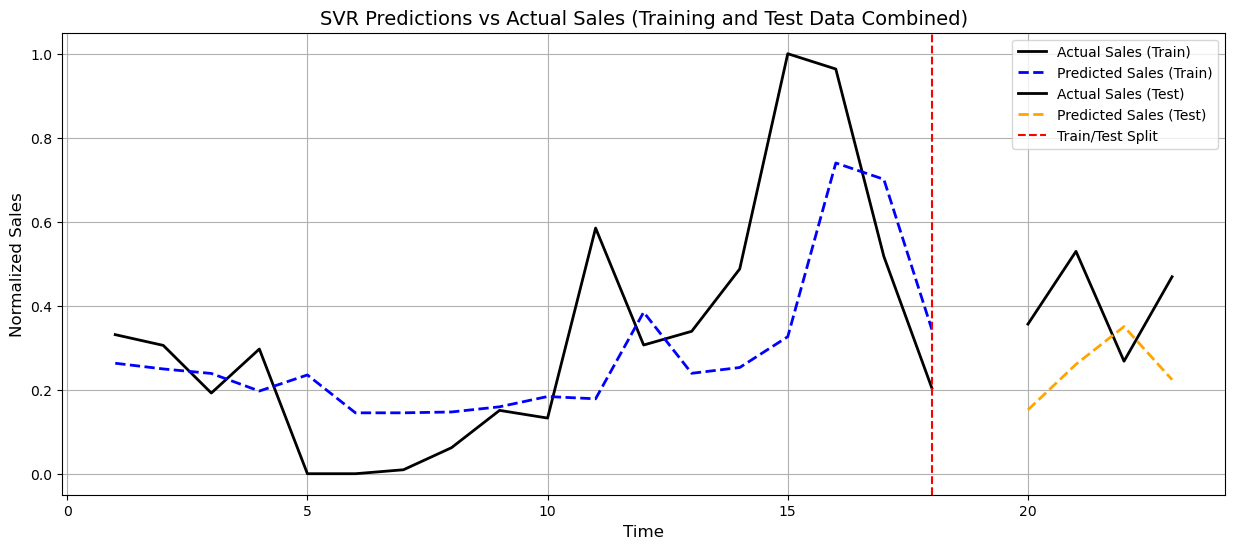

In [82]:
# Plot both Training vs Test predictions together with vertical split
plt.figure(figsize=(15, 6))

# Plot actual sales for the training data
plt.plot(train_data.index, train_data['Normalized_Sales'], label="Actual Sales (Train)", color='black', linewidth=2)

# Plot predicted sales for the training set
plt.plot(train_data.index, train_predictions, linestyle='--', label="Predicted Sales (Train)", color='blue', linewidth=2)

# Plot actual sales for the testing data
plt.plot(test_data.index, test_data['Normalized_Sales'], label="Actual Sales (Test)", color='black', linewidth=2)

# Plot predicted sales for the testing set
plt.plot(test_data.index, predSVR, linestyle='--', label="Predicted Sales (Test)", color='orange', linewidth=2)

# Separate training and testing data with a vertical line
cutoff_date = train_data.index[-1]  # Mark the split point using the last date from the training set
plt.axvline(cutoff_date, color='red', linestyle='--', label='Train/Test Split')

# Add labels, legend, and grid
plt.xlabel("Time", fontsize=12)
plt.ylabel("Normalized Sales", fontsize=12)
plt.title("SVR Predictions vs Actual Sales (Training and Test Data Combined)", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [83]:
# Linear Regression

In [84]:
# Initialize the Linear Regression model
linearReg = LinearRegression()

# Train model
linearReg.fit(X_train, y_train.ravel())


LinearRegression()

In [85]:
# Predictions for Train Data
train_data['Predictions_LR'] = linearReg.predict(X_train)

# Predictions for Test Data
test_data['Predictions_LR'] = linearReg.predict(X_test)

In [86]:
# Calculate evaluation metrics
rmse_test = mean_squared_error(y_test, test_data['Predictions_LR'], squared=False)
mape_test = mean_absolute_percentage_error(y_test, test_data['Predictions_LR'])

# Print results
print(f"Testing RMSE: {rmse_test}")
print(f"Testing MAPE: {mape_test}")

Testing RMSE: 0.1532196833246415
Testing MAPE: 0.33754093949942965


C:\Users\Jay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [92]:
# Calculate R-squared for training and testing
r2_train_lr = r2_score(y_train, train_data['Predictions_LR'])
r2_test_lr = r2_score(y_test, test_data['Predictions_LR'])

# Display R-squared results
print(f"R-squared (Train) for Linear Regression: {r2_train_lr:.2f}")
print(f"R-squared (Test) for Linear Regression: {r2_test_lr:.2f}")

R-squared (Train) for Linear Regression: 0.49
R-squared (Test) for Linear Regression: -1.30


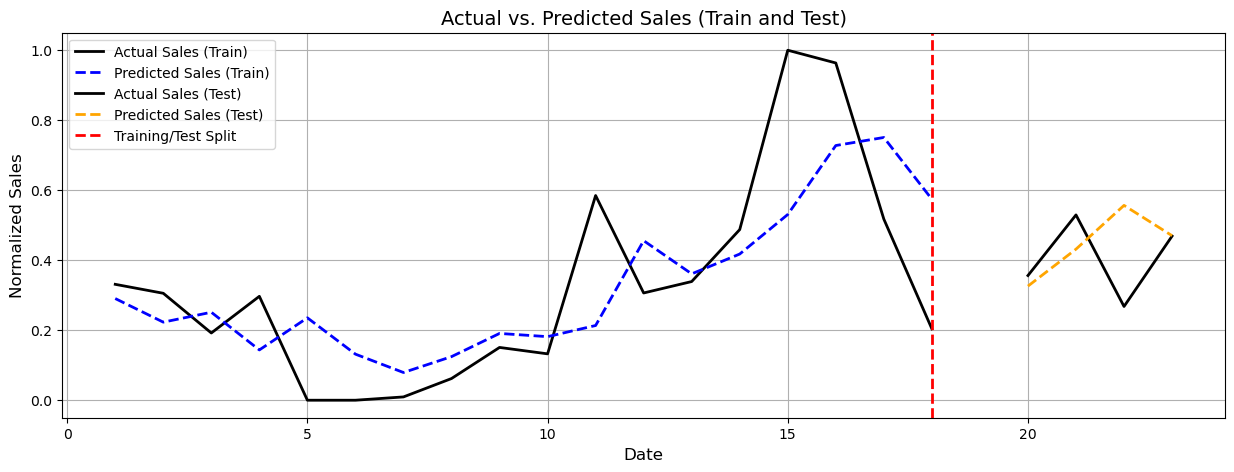

In [93]:
plt.figure(figsize=(15, 5))

# Plot actual sales (training data)
plt.plot(
    train_data.index, train_data['Normalized_Sales'], 
    label='Actual Sales (Train)', color='black', linewidth=2
)

# Plot predicted sales (training data)
plt.plot(
    train_data.index, train_data['Predictions_LR'], 
    label='Predicted Sales (Train)', color='blue', linestyle='--', linewidth=2
)

# Plot actual sales (testing data)
plt.plot(
    test_data.index, test_data['Normalized_Sales'], 
    label='Actual Sales (Test)', color='black', linewidth=2
)

# Plot predicted sales (testing data)
plt.plot(
    test_data.index, test_data['Predictions_LR'], 
    label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2
)

# Add a vertical line to mark the training/testing split
cutoff_date = train_data.index[-1]  # Last date of the training set
plt.axvline(cutoff_date, color='red', linestyle='--', label='Training/Test Split', linewidth=2)

# Add labels, title, legend, and grid
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Sales", fontsize=12)
plt.title("Actual vs. Predicted Sales (Train and Test)", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [94]:
# Random Forest Implementation

In [95]:
# Function to train Random Forest with hyperparameter tuning using GridSearchCV
def train_random_forest_grid(X_train, y_train):
    # Create the Random Forest Regressor
    randomForestModel = RandomForestRegressor(random_state=1)

    # Define the hyperparameter grid
    param_grid = {
        "n_estimators": [500, 1000, 1500],  # Number of trees in the forest
        "max_depth": [None, 10, 20, 30],
        "max_features": [2, 4, 6, 'auto'],  # Number of features to consider at each split
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    }

    # Initialize GridSearchCV for hyperparameter optimization
    grid_search = GridSearchCV(
        estimator=randomForestModel,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,  # Use all available cores
        scoring='neg_mean_squared_error'  # Using MSE as a scoring metric
    )

    # Fit the model with the provided training data
    grid_search.fit(X_train, y_train)

    # Print best parameters
    print("Best Hyperparameters found:")
    print(grid_search.best_params_)

    # Return the best model
    best_model = grid_search.best_estimator_
    return best_model

In [96]:
# Train the model using GridSearchCV
randomForestModel = train_random_forest_grid(X_train, y_train)

C:\Users\Jay\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
143 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jay\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jay\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jay\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jay\anaconda3\Lib\site-packages\sklear

Best Hyperparameters found:
{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [97]:
# Make predictions on training and testing sets
predRF_train = randomForestModel.predict(X_train)  # Predictions on the training set
predRF_test = randomForestModel.predict(X_test)  # Predictions on the test set

# Store these predictions for plotting
train_data["Predictions_RF"] = predRF_train
test_data["Predictions_RF"] = predRF_test

In [98]:
# Compute RMSE and MAPE for training and testing sets
rmse_RF_train = np.sqrt(mean_squared_error(y_train, predRF_train))
rmse_RF_test = np.sqrt(mean_squared_error(y_test, predRF_test))
mape_RF_train = mean_absolute_percentage_error(y_train, predRF_train)
mape_RF_test = mean_absolute_percentage_error(y_test, predRF_test)

# Print evaluation metrics
print(f"RMSE (Train): {rmse_RF_train}")
print(f"RMSE (Test): {rmse_RF_test}")
print(f"MAPE (Train): {mape_RF_train:.2%}")
print(f"MAPE (Test): {mape_RF_test:.2%}")


RMSE (Train): 0.09184551955357048
RMSE (Test): 0.13727329328089338
MAPE (Train): 2634021066610845.00%
MAPE (Test): 30.09%


In [99]:
# Calculate R-squared for training and testing
r2_RF_train = r2_score(y_train, predRF_train)
r2_RF_test = r2_score(y_test, predRF_test)

# Display R-squared results
print(f"R-squared (Train) for SVR: {r2_RF_train:.2f}")
print(f"R-squared (Test) for SVR: {r2_RF_test:.2f}")

R-squared (Train) for SVR: 0.90
R-squared (Test) for SVR: -0.85


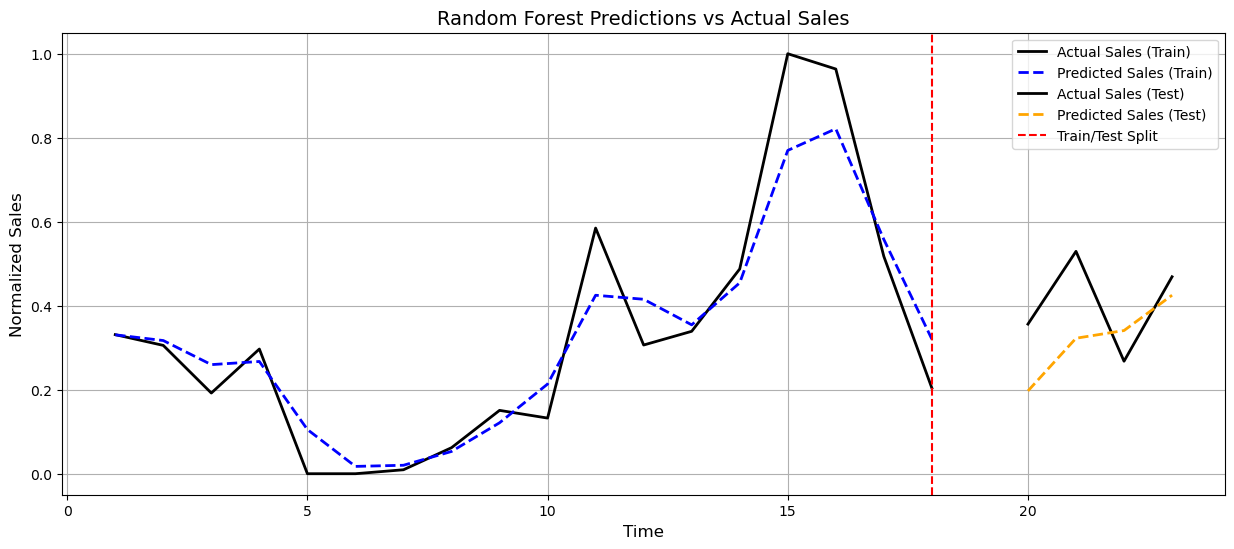

In [100]:
# Make predictions on training and testing sets
predRF_train = randomForestModel.predict(X_train)  # Predictions on the training set
predRF_test = randomForestModel.predict(X_test)  # Predictions on the test set

# Store these predictions for plotting in the correct dataset
train_data["Predictions_RF"] = predRF_train
test_data["Predictions_RF"] = predRF_test

# Plot training vs actual and test vs actual comparisons
plt.figure(figsize=(15, 6))

# Training predictions
plt.plot(train_data.index, train_data["Normalized_Sales"], label="Actual Sales (Train)", color="black", linewidth=2)
plt.plot(train_data.index, train_data["Predictions_RF"], linestyle="--", label="Predicted Sales (Train)", color="blue", linewidth=2)

# Testing predictions
plt.plot(test_data.index, test_data["Normalized_Sales"], label="Actual Sales (Test)", color="black", linewidth=2)
plt.plot(test_data.index, test_data["Predictions_RF"], linestyle="--", label="Predicted Sales (Test)", color="orange", linewidth=2)

# Vertical line separating train/test split
cutoff_date = train_data.index[-1]  # Use the last date from the training set
plt.axvline(cutoff_date, color="red", linestyle="--", label="Train/Test Split")

# Labels, legend, title
plt.xlabel("Time", fontsize=12)
plt.ylabel("Normalized Sales", fontsize=12)
plt.title("Random Forest Predictions vs Actual Sales", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [101]:
# XG Boost Implementation

In [102]:
# Initialize the XGBoost regressor
xgBoostReg = xgb.XGBRegressor(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [1000, 2000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgBoostReg,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

# Fit the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model from GridSearch
best_xgBoostReg = grid_search.best_estimator_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8}


In [103]:
# Predict on train and test data
predXGBoost_train = best_xgBoostReg.predict(X_train)
predXGBoost_test = best_xgBoostReg.predict(X_test)

# Add predictions to the dataframes
train_data["Predictions_XGBoost"] = predXGBoost_train
test_data["Predictions_XGBoost"] = predXGBoost_test

In [104]:
# Evaluate RMSE and MAPE
rmse_XGBoost_train = np.sqrt(mean_squared_error(y_train, predXGBoost_train))
rmse_XGBoost_test = np.sqrt(mean_squared_error(y_test, predXGBoost_test))
mape_XGBoost_train = mean_absolute_percentage_error(y_train, predXGBoost_train)
mape_XGBoost_test = mean_absolute_percentage_error(y_test, predXGBoost_test)

# Print the evaluation metrics
print(f"RMSE (Train): {rmse_XGBoost_train}")
print(f"RMSE (Test): {rmse_XGBoost_test}")
print(f"MAPE (Train): {mape_XGBoost_train:.2%}")
print(f"MAPE (Test): {mape_XGBoost_test:.2%}")

RMSE (Train): 0.0005886490418349113
RMSE (Test): 0.18357836750574882
MAPE (Train): 4988656025876.17%
MAPE (Test): 32.94%


In [105]:
# Calculate R-squared for training and testing
r2_train_xgb = r2_score(y_train, predXGBoost_train)
r2_test_xgb = r2_score(y_test, predXGBoost_test)

# Display R-squared results
print(f"R-squared (Train) for XGBoost: {r2_train_xgb:.2f}")
print(f"R-squared (Test) for XGBoost: {r2_test_xgb:.2f}")

R-squared (Train) for XGBoost: 1.00
R-squared (Test) for XGBoost: -2.31


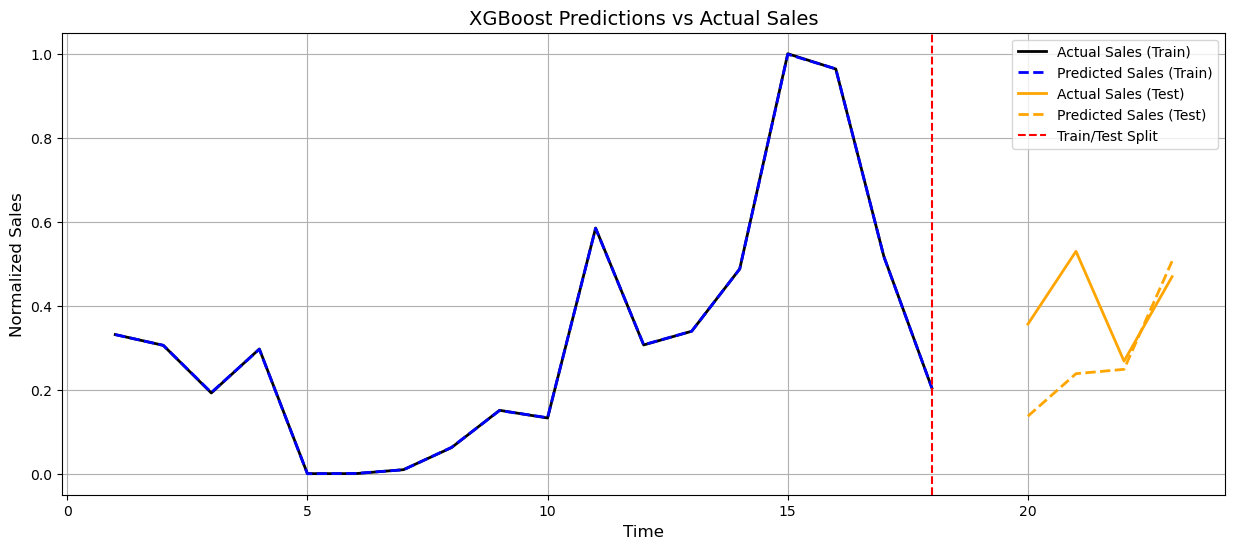

In [106]:
# Plot training vs actual and test vs actual comparisons
plt.figure(figsize=(15, 6))

# Training period
plt.plot(train_data.index, train_data["Normalized_Sales"], label="Actual Sales (Train)", color="black", linewidth=2)
plt.plot(train_data.index, train_data["Predictions_XGBoost"], linestyle="--", label="Predicted Sales (Train)", color="blue", linewidth=2)

# Testing period
plt.plot(test_data.index, test_data["Normalized_Sales"], label="Actual Sales (Test)", color="orange", linewidth=2)
plt.plot(test_data.index, test_data["Predictions_XGBoost"], linestyle="--", label="Predicted Sales (Test)", color="orange", linewidth=2)

# Vertical line separating train/test split
cutoff_date = train_data.index[-1]
plt.axvline(cutoff_date, color="red", linestyle="--", label="Train/Test Split")

# Set labels and legend
plt.xlabel("Time", fontsize=12)
plt.ylabel("Normalized Sales", fontsize=12)
plt.title("XGBoost Predictions vs Actual Sales", fontsize=14)
plt.legend()
plt.grid()
plt.show()